# 图像Softmax分类器

和图像SVM分类器一样，我们在这里用不同的损失函数实现一个Softmax分类器：

- 完成基于互熵损失的Softmax分类器
- 完成解析梯度的向量化计算
- 会用数值梯度去校验解析梯度的准确性
- 用验证集去调正则化和学习率
- 用随机梯度下降最小化损失函数
- 可视化结果权重

In [1]:
import random
import numpy as np
from basic.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # 设定绘图参数
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  """
  把CIFAR-10数据集读入，并预处理成线性分类器能用的格式 
  """
  # 读入数据集
  cifar10_dir = 'basic/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # 去一部分数据用
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  # 预处理：把数据展成一列
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  
  # 减掉图像均值，做0均值处理
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  
  # 咱把bias那一项加上
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]).T
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]).T
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]).T
  
  return X_train, y_train, X_val, y_val, X_test, y_test


# 调用函数得到各种数据，并输出维度
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (3073, 49000)
Train labels shape:  (49000,)
Validation data shape:  (3073, 1000)
Validation labels shape:  (1000,)
Test data shape:  (3073, 1000)
Test labels shape:  (1000,)


## Softmax 分类器

具体的softmax分类器代码可以看 **basic/classifiers/softmax.py**. 


In [3]:
# 同样实现一个非常易懂但是效率很低的softmax损失函数计算

from basic.classifiers.softmax import softmax_loss_naive
import time

# 随便初始化一个权重序列，然后计算损失函数
W = np.random.randn(10, 3073) * 0.0001
loss, grad = softmax_loss_naive(W, X_train, y_train, 0.0)

# 总共有10类，如果我们随机猜，损失应该是-log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.431932
sanity check: 2.302585


In [5]:
# 用多层for循环实现一个梯度计算
loss, grad = softmax_loss_naive(W, X_train, y_train, 0.0)

# 同样要做一下梯度检查
from basic.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.110578 analytic: -0.110579, relative error: 0.000
numerical: -0.576297 analytic: -0.576297, relative error: 0.000
numerical: -0.667831 analytic: -0.667831, relative error: 0.000
numerical: 2.557195 analytic: 2.557195, relative error: 0.000
numerical: -0.586606 analytic: -0.586606, relative error: 0.000
numerical: 0.488324 analytic: 0.488324, relative error: 0.000
numerical: 0.469573 analytic: 0.469573, relative error: 0.000
numerical: -0.633575 analytic: -0.633575, relative error: 0.000
numerical: 0.348785 analytic: 0.348785, relative error: 0.000
numerical: 0.030318 analytic: 0.030318, relative error: 0.000


In [8]:
# 实现一个非向量化的损失函数和梯度计算方法
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_train, y_train, 0.00001)
toc = time.time()
print '非向量化的损失计算结果: %e ，花费时间 %fs' % (loss_naive, toc - tic)

# 调用向量化的损失函数和梯度计算函数
from basic.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_train, y_train, 0.00001)
toc = time.time()
print '向量化的损失计算结果: %e ，花费时间 %fs' % (loss_vectorized, toc - tic)

# 咱们对比一下用for循环实现的函数和用向量化实现的函数差别
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print '两种方法计算到的loss差异: %f' % np.abs(loss_naive - loss_vectorized)
print '两种方法计算到的梯度差异: %f' % grad_difference

非向量化的损失计算结果: 2.431932e+00 ，花费时间 3.969373s
向量化的损失计算结果: 2.431932e+00 ，花费时间 0.183363s
两种方法计算到的loss差异: 0.000000
两种方法计算到的梯度差异: 0.000000


In [9]:
# 咱们实现了一个softmax分类器
from basic.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [5e-7, 1e-7, 5e-6, 1e-6]
regularization_strengths = [5e4, 1e5]

import sys
verbose = True
for lr in learning_rates:
    for reg in regularization_strengths:
        if verbose: sys.stdout.write("Training with hyper parameter learning rate: %e, regularization: %e\n" 
                                     % ( lr, reg ))
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=1500, verbose=False)
        
        y_train_pred = softmax.predict(X_train)
        training_accuracy = np.mean(y_train == y_train_pred)
        
        y_val_pred = softmax.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        
        results[lr, reg] = (training_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax
                
# 输出结果
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print '学习率 %e 正则化系数 %e 训练准确率: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print '在交叉验证集上最好的准确率为: %f' % best_val

Training with hyper parameter learning rate: 5.000000e-07, regularization: 5.000000e+04
Training with hyper parameter learning rate: 5.000000e-07, regularization: 1.000000e+05
Training with hyper parameter learning rate: 1.000000e-07, regularization: 5.000000e+04
Training with hyper parameter learning rate: 1.000000e-07, regularization: 1.000000e+05
Training with hyper parameter learning rate: 5.000000e-06, regularization: 5.000000e+04
Training with hyper parameter learning rate: 5.000000e-06, regularization: 1.000000e+05
Training with hyper parameter learning rate: 1.000000e-06, regularization: 5.000000e+04
Training with hyper parameter learning rate: 1.000000e-06, regularization: 1.000000e+05
学习率 1.000000e-07 正则化系数 5.000000e+04 训练准确率: 0.329408 val accuracy: 0.345000
学习率 1.000000e-07 正则化系数 1.000000e+05 训练准确率: 0.307122 val accuracy: 0.320000
学习率 5.000000e-07 正则化系数 5.000000e+04 训练准确率: 0.330673 val accuracy: 0.343000
学习率 5.000000e-07 正则化系数 1.000000e+05 训练准确率: 0.308163 val accuracy: 0.316

In [10]:
# 在测试集上评估softmax分类器性能
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print '基于图像像素数据的softmax分类器在测试集上的准确率: %f' % (test_accuracy, )

基于图像像素数据的softmax分类器在测试集上的准确率: 0.342000


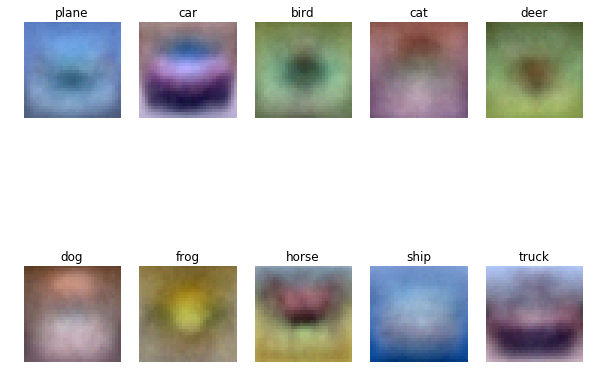

In [11]:
# 可视化一下学习到的权重
w = best_softmax.W[:,:-1] # strip out the bias
w = w.reshape(10, 32, 32, 3)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])